<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

<div style="border:solid blue 2px; padding: 20px">
Привет Елена! Меня зовут Андрей Петрушин, я буду проверять твой проект. Предлагаю общаться на «ты», это упрощает коммуникацию :) Но если это некомфортно - можем перейти на “Вы”.

Вижу, что тобой проделана большая работа над проектом и он выполнен на хорошем уровне. Моя основная цель при проверке работы — помочь сделать проект лучше и возможно, поделиться своим опытом решения подобных задач.

Я буду делать комментарии четырьмя цветами:

<font color='blue'>Комментарий ревьювера синий текст - просто текст комментария</font>
    
<font color="green">Комментарий ревьювера   
✔️ зеленый текст - все отлично, хорошее решение</font>
    
<font color="darkorange">Комментарий ревьювера    
⚠️ оранжевый текст - есть рекомендации, в другой раз можно сделать иначе</font>
    
<font color="red">Комментарий ревьювера   
❌ красный текст - есть недочеты, их нужно исправить и проект будет принят</font>
    
Пожалуйста, не удаляй мои комментарии, нам обоим будет проще разобраться в недочетах, что и как исправлено. Свои комментарии тоже отмечай, например другим цветом или надписью “Комментарий студента”. 

\<font color='purple'> Этот код позволяет менять цвет текста. \</font>
</div>


<font color='blue'> Комментарий студента. Андрей, привет! Спасибо за оперативную проверку. Все критические замечания я исправила.

<font color="green">Комментарий ревьювера 2   
✔️ Хорошо!</font>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<font color="green">Комментарий ревьювера   
✔️ Хорошо, что ты приводишь описание проекта</font>

## Подготовка данных

Откроем файл с данными и ознакомимся с ними, открыв первые пять строк и вызвав функцию .info()

In [1]:
#Импортируем необходимые для работы библиотеки:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score 
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Откроем файл
data = pd.read_csv('/datasets/Churn.csv')

#Ознакомимся с данными:
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<font color="green">Комментарий ревьювера   
✔️ Молодец, что весь импорт библиотек в начале проекта</font>

<font color="darkorange">Комментарий ревьвюера    
⚠️ Не стоит в ячейку с импортом помещать исполняемый код, загрузку файла. </font>
</font>

Изучив данные можно прийти к следующему выводу:
1. в таблице есть колонки, которые очевидно не будут влиять на обучаемость модели (фамилии, уникальный идентификатор клиента)
2. таблица содержит пропуски в столбце о времени обслуживания клиентов в банке. Данный столбец проанализируем отдельно, чтобы понять как поступить с пропущенными значениями. 

<font color="darkorange">Комментарий ревьвюера    
⚠️ Хорошо бы еще дать описание колонок </font>

<font color="red">Комментарий ревьювера   
❌ Не совсем понял фразу "о времени обслуживания клиентов в банке". Пропуски есть только у Tenure — количество недвижимости у клиента</font>

<font color='blue'>Комментарий студента. Речь идет как раз о колонке Tenure. В описании задачи говорится о том, что значения данной колонки -  сколько лет человек является клиентом банка. Количество лет обслуживания в банке не зависит ни от одного столбца в таблице.По логике, заполнить значения средним или медианой нельзя, так как в таком случае мы можем получить искажение данных. Поэтому я провела анализ, насколько данные значения вообще влияют на целевой признак и выявила, зависимости нет. Поэтому мною было принято решение об удалении столбца.

<font color="green">Комментарий ревьювера 2   
✔️ Это право датасайнтиста :)</font>

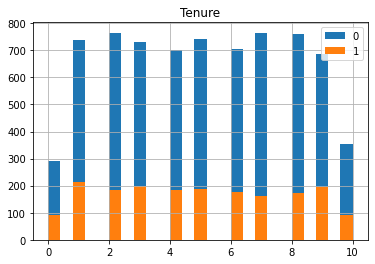

Коэффициент корреляции: -0.016761481514933764


In [2]:
#Выведем на экран гистограмму, 
#которая отражает доли ушедших клиентов из банка в разрезе каждого значения данного столбца.
data_a = data.query('Exited == 1')
data_b = data.query('Exited == 0')
data_b['Tenure'].hist(bins = 25,label = '0')
data_a['Tenure'].hist(bins = 25,label = '1')
plt.legend()
plt.title('Tenure')
plt.show()

#Посчитаем коэффициент корреляции:
print('Коэффициент корреляции:', data['Tenure'].corr(data['Exited']))


<font color="green">Комментарий ревьювера   
✔️ Молодец, хороший анализ</font>

Судя по данным, значения доли ушедших клиентов примерно одинаково в разрезе каждого значения срока обслуживания. Таким образом можно сделать вывод о том, что данный показатель не является значимым, и его можно не брать во внимание при обучении модели.
Данное предположение мы подтвердили, посчитав коэффициент корреляции, который оказался близким к 0.

Уберем лишние столбцы:

In [3]:
data = data.drop(['Surname','Tenure','CustomerId','RowNumber'],axis=1)

<font color="darkorange">Комментарий ревьвюера    
⚠️ Смелое решение относительно 'Tenure'! Я бы все-таки рекомендовал не удалять столбцы, если они потенциально могут оказать влияние на результат :)</font>

В оставшихся ячейках изучим корреляции в данных. Так мы можем оценить взаимосвязи в данных и влияние параметров на целевой признак. Воспользуемся для этого методом `sns.pairplot` с параметром hue, в который мы передаем целевой признак.


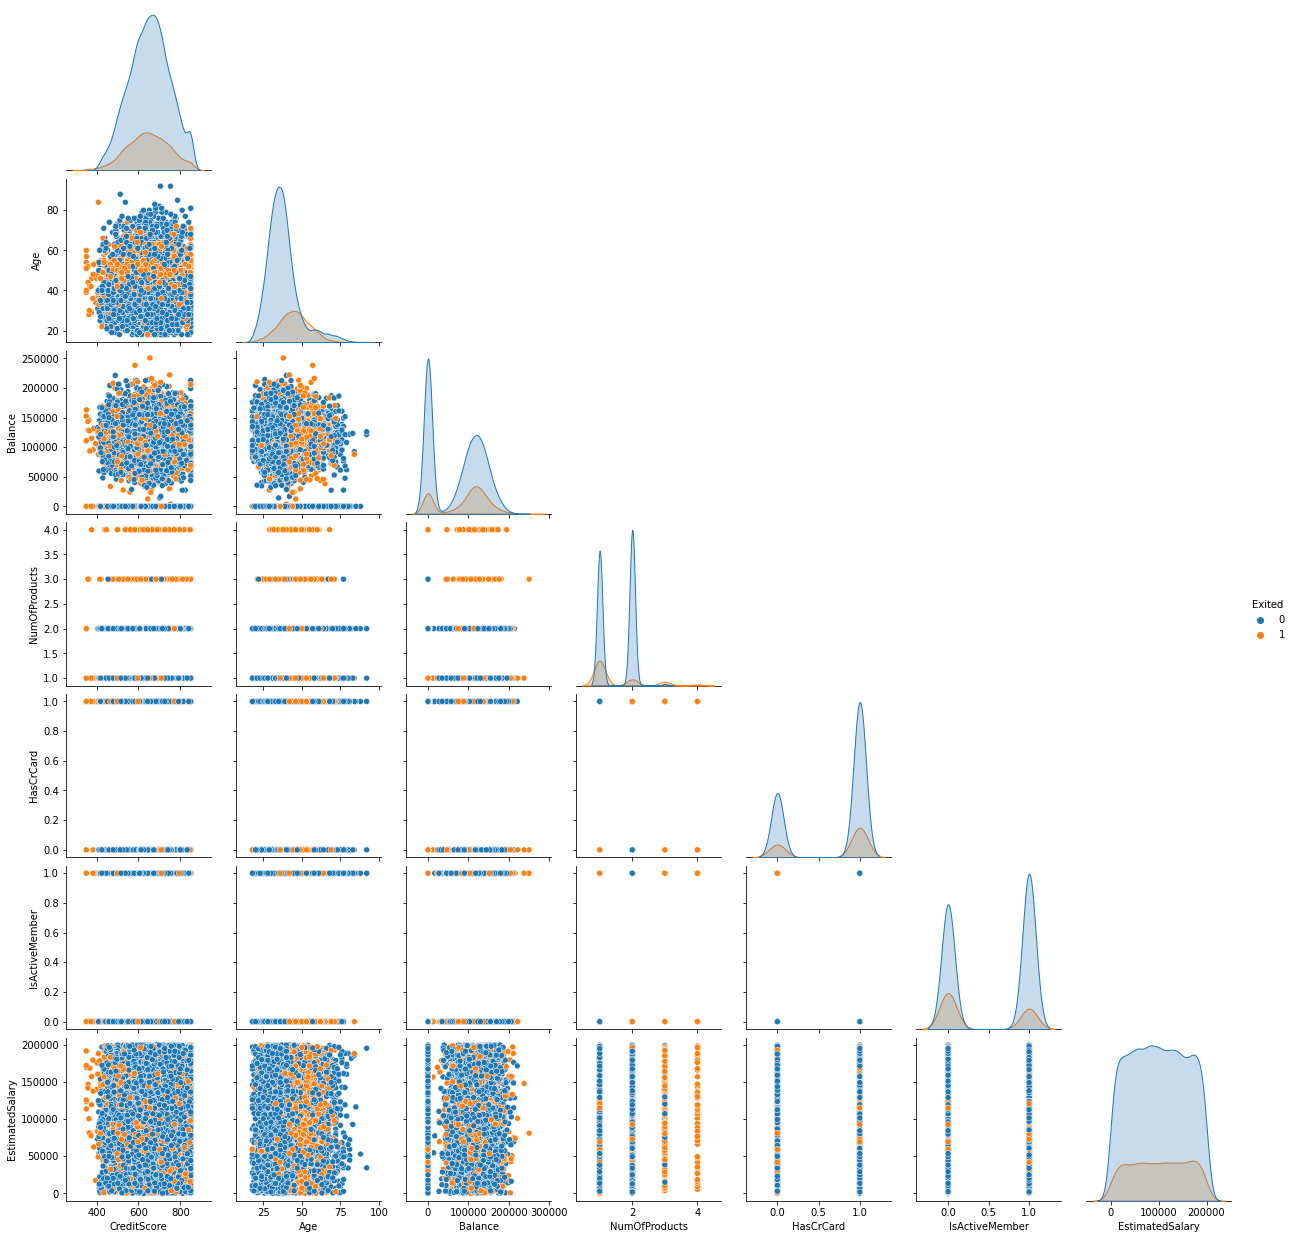

In [4]:
sns.pairplot(data,hue = 'Exited',corner=True)

На графике видны определенные закономерности в признаках - среди ушедших больше людей среднего возраста (от 40 до 60 лет) с количеством продуктов более 2 и невысоким кредитным рейтингом

<font color="green">Комментарий ревьювера   
✔️ Хорошо</font>

Преобразуем категориальные признаки в численные с помощью техники One-Hot Encoding, а для избежания дамми-ловушки, применим аругмент drop_first и удалим лишние столбцы.

In [5]:
data_ohe = pd.get_dummies(data, drop_first=True)

<font color="darkorange">Комментарий ревьювера    
⚠️ Все верно, это самый простой способ кодирования. Но обрати внимание - ты передаешь весь датасет вместо категориальных столбцов. Небольшое дополнение - в get_dummies желательно передавать параметр columns (это столбцы, которые мы преобразуем).
 
Еще хочу посоветовать - проверить на аномалии колонки география и пол. Если например там есть описки, то ты получишь лишний столбец :) . В этом учебном датасете все хорошо, но так бывает очень редко!</font>

## Исследование задачи

Мы преобразовали данные для дальнейшего анализа и обучения модели. Теперь разобьем нашу выборку на три в пропорции 20\20\60. Так мы получим тестовую, обучающую и валидационную выборки.

In [6]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)
#Выделим тестовую выборку (20% от общих данных)
features_other, features_test, target_other, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)
#Выделим валидационную и обучающую выборки:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_other, target_other, test_size=0.2, random_state=12345)

#Стандартизируем признаки:
numerik = ['CreditScore','Age','Balance','EstimatedSalary','NumOfProducts']
scaler = StandardScaler()
scaler.fit(features_train[numerik]) 
features_train[numerik] = scaler.transform(features_train[numerik])
features_valid[numerik] = scaler.transform(features_valid[numerik])
features_test[numerik] = scaler.transform(features_test[numerik]) 

pd.options.mode.chained_assignment = None 

#Обучим модель на полученных данных:
model = DecisionTreeClassifier(random_state = 12345)
model.fit(features_train,target_train)
predicted_valid_dtc = model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid,predicted_valid_dtc)
f1_dtc = f1_score(target_valid,predicted_valid_dtc)
auc_roc_dtc = roc_auc_score(target_valid,predicted_valid_dtc)
print('Значение accuracy - {} | F1 - {:.3f}| auc-roc -{:.3f}'.format(accuracy_valid,f1_dtc,auc_roc_dtc))



Значение accuracy - 0.8 | F1 - 0.472| auc-roc -0.674


/tmp/ipykernel_54/1482309962.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numerik] = scaler.transform(features_train[numerik])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_54/1482309962.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

Построим константную модель и сравним с деревом решений.

<font color="darkorange">Комментарий ревьювера    
⚠️ Чтобы убрать предупреждения можно указать в ячейке с библиотеками:   
warnings.filterwarnings('ignore')</font>
 

In [7]:
target_pred_constant = pd.Series(target*0)
print(accuracy_score(target, target_pred_constant)) 


0.7963


accuracy решающего дерева и константной модели почти одинаковы. В нашей задаче наблюдается сильный дисбаланс классов (англ. class imbalance), что плохо сказывается на обучении модели.

## Борьба с дисбалансом

Создадим 4 выборки методами upsampling и downsampling

In [8]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

<font color="green">Комментарий ревьювера   
✔️ Хорошие функции</font>

По полученным выборкам обучим несколько моделей и посмотрим, какая из них даст наилучший результат. Начнем с логистической регрессии:


In [9]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_upsampled, target_upsampled)
probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.05):
    predicted_valid_lr = probabilities_one_valid > threshold
    precision = precision_score(target_valid,predicted_valid_lr)
    recall = recall_score(target_valid,predicted_valid_lr)
    auc_roc = roc_auc_score(target_valid, predicted_valid_lr)
    f1 = f1_score(target_valid, predicted_valid_lr)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, auc-roc = {:.3f}, F1 ={:.3f}".format(
        threshold, precision, recall,auc_roc,f1))
    

Порог = 0.00 | Точность = 0.189, Полнота = 1.000, auc-roc = 0.500, F1 =0.318
Порог = 0.05 | Точность = 0.189, Полнота = 1.000, auc-roc = 0.500, F1 =0.318
Порог = 0.10 | Точность = 0.189, Полнота = 1.000, auc-roc = 0.500, F1 =0.318
Порог = 0.15 | Точность = 0.189, Полнота = 0.997, auc-roc = 0.499, F1 =0.318
Порог = 0.20 | Точность = 0.191, Полнота = 0.997, auc-roc = 0.506, F1 =0.321
Порог = 0.25 | Точность = 0.193, Полнота = 0.990, auc-roc = 0.512, F1 =0.323
Порог = 0.30 | Точность = 0.201, Полнота = 0.987, auc-roc = 0.535, F1 =0.334
Порог = 0.35 | Точность = 0.210, Полнота = 0.987, auc-roc = 0.560, F1 =0.347
Порог = 0.40 | Точность = 0.222, Полнота = 0.970, auc-roc = 0.587, F1 =0.361
Порог = 0.45 | Точность = 0.235, Полнота = 0.954, auc-roc = 0.615, F1 =0.377
Порог = 0.50 | Точность = 0.249, Полнота = 0.931, auc-roc = 0.637, F1 =0.393
Порог = 0.55 | Точность = 0.267, Полнота = 0.908, auc-roc = 0.663, F1 =0.413
Порог = 0.60 | Точность = 0.286, Полнота = 0.842, auc-roc = 0.676, F1 =0.427

In [10]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_downsampled, target_downsampled)
probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.05):
    predicted_valid_lr = probabilities_one_valid > threshold
    precision = precision_score(target_valid,predicted_valid_lr)
    recall = recall_score(target_valid,predicted_valid_lr)
    auc_roc = roc_auc_score(target_valid, predicted_valid_lr)
    f1 = f1_score(target_valid, predicted_valid_lr)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, auc-roc = {:.3f}, F1 ={:.3f}".format(
        threshold, precision, recall,auc_roc,f1))
    

Порог = 0.00 | Точность = 0.189, Полнота = 1.000, auc-roc = 0.500, F1 =0.318
Порог = 0.05 | Точность = 0.189, Полнота = 1.000, auc-roc = 0.500, F1 =0.318
Порог = 0.10 | Точность = 0.189, Полнота = 1.000, auc-roc = 0.500, F1 =0.318
Порог = 0.15 | Точность = 0.189, Полнота = 0.997, auc-roc = 0.499, F1 =0.318
Порог = 0.20 | Точность = 0.191, Полнота = 0.997, auc-roc = 0.505, F1 =0.320
Порог = 0.25 | Точность = 0.194, Полнота = 0.990, auc-roc = 0.514, F1 =0.324
Порог = 0.30 | Точность = 0.201, Полнота = 0.990, auc-roc = 0.535, F1 =0.334
Порог = 0.35 | Точность = 0.209, Полнота = 0.983, auc-roc = 0.556, F1 =0.344
Порог = 0.40 | Точность = 0.218, Полнота = 0.964, auc-roc = 0.579, F1 =0.356
Порог = 0.45 | Точность = 0.232, Полнота = 0.954, auc-roc = 0.608, F1 =0.373
Порог = 0.50 | Точность = 0.248, Полнота = 0.941, auc-roc = 0.638, F1 =0.393
Порог = 0.55 | Точность = 0.263, Полнота = 0.894, auc-roc = 0.655, F1 =0.407
Порог = 0.60 | Точность = 0.283, Полнота = 0.838, auc-roc = 0.671, F1 =0.423

In [11]:
for depth in range(1, 20, 1):
    model_a = RandomForestClassifier(n_estimators=15, max_depth=depth, random_state=12345)
    model_a.fit(features_upsampled, target_upsampled)
    predicted_valid_a = model_a.predict(features_valid)
    auc_roc = roc_auc_score(target_valid, predicted_valid_a)
    f1 = f1_score(target_valid, predicted_valid_a)
    print("Глубина = {:.2f} | F1 ={:.3f} | auc-roc = {:.3f}".format(
        depth, f1, auc_roc,))
    


Глубина = 1.00 | F1 =0.318 | auc-roc = 0.500
Глубина = 2.00 | F1 =0.318 | auc-roc = 0.500
Глубина = 3.00 | F1 =0.349 | auc-roc = 0.565
Глубина = 4.00 | F1 =0.404 | auc-roc = 0.654
Глубина = 5.00 | F1 =0.411 | auc-roc = 0.663
Глубина = 6.00 | F1 =0.449 | auc-roc = 0.703
Глубина = 7.00 | F1 =0.457 | auc-roc = 0.711
Глубина = 8.00 | F1 =0.484 | auc-roc = 0.734
Глубина = 9.00 | F1 =0.506 | auc-roc = 0.748
Глубина = 10.00 | F1 =0.519 | auc-roc = 0.750
Глубина = 11.00 | F1 =0.556 | auc-roc = 0.769
Глубина = 12.00 | F1 =0.562 | auc-roc = 0.765
Глубина = 13.00 | F1 =0.539 | auc-roc = 0.737
Глубина = 14.00 | F1 =0.559 | auc-roc = 0.743
Глубина = 15.00 | F1 =0.591 | auc-roc = 0.761
Глубина = 16.00 | F1 =0.585 | auc-roc = 0.754
Глубина = 17.00 | F1 =0.591 | auc-roc = 0.753
Глубина = 18.00 | F1 =0.583 | auc-roc = 0.746
Глубина = 19.00 | F1 =0.586 | auc-roc = 0.747


In [12]:
for depth in range(1, 20, 1):
    model_b = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=12345)
    model_b.fit(features_downsampled, target_downsampled)
    predicted_valid_b = model_b.predict(features_valid)
    auc_roc = roc_auc_score(target_valid, predicted_valid_b)
    f1 = f1_score(target_valid, predicted_valid_b)
    print("Глубина = {:.2f} | F1 ={:.3f} | auc-roc = {:.3f}".format(
        depth, f1, auc_roc))

Глубина = 1.00 | F1 =0.318 | auc-roc = 0.500
Глубина = 2.00 | F1 =0.319 | auc-roc = 0.500
Глубина = 3.00 | F1 =0.368 | auc-roc = 0.599
Глубина = 4.00 | F1 =0.382 | auc-roc = 0.622
Глубина = 5.00 | F1 =0.406 | auc-roc = 0.657
Глубина = 6.00 | F1 =0.429 | auc-roc = 0.686
Глубина = 7.00 | F1 =0.443 | auc-roc = 0.701
Глубина = 8.00 | F1 =0.443 | auc-roc = 0.700
Глубина = 9.00 | F1 =0.451 | auc-roc = 0.708
Глубина = 10.00 | F1 =0.460 | auc-roc = 0.719
Глубина = 11.00 | F1 =0.456 | auc-roc = 0.712
Глубина = 12.00 | F1 =0.451 | auc-roc = 0.707
Глубина = 13.00 | F1 =0.458 | auc-roc = 0.714
Глубина = 14.00 | F1 =0.456 | auc-roc = 0.711
Глубина = 15.00 | F1 =0.457 | auc-roc = 0.713
Глубина = 16.00 | F1 =0.456 | auc-roc = 0.712
Глубина = 17.00 | F1 =0.456 | auc-roc = 0.711
Глубина = 18.00 | F1 =0.462 | auc-roc = 0.718
Глубина = 19.00 | F1 =0.459 | auc-roc = 0.714


Наилучший результат мы получили от модели RandomForestClassifier с количеством деревьев 15, глубиной - 15. Проверим как поведет себя модель на тестовой выборке.

<font color="green">Комментарий ревьювера   
✔️ По коду все хорошо!</font>

<font color="darkorange">Комментарий ревьювера    
⚠️ Еще желательно написать, как изменяется AUC-ROC относительно F1 для разных моделей. Оба растут или изменение в разных направлениях</font>


<font color="red">Комментарий ревьювера   
❌ Очень рекомендуется подписывать ячейки и вывод данных - что мы ищем.   
Нужно обязательно написать вывод - с какими парамтерами, моделями какие результаты F1, AUC-ROC получены</font>


<font color='blue'>Комментарий студента. Не очень поняла данное замечание - кажется на выводе данных указаны названия всех параметров, которые ищем. Ниже написала общий вывод.

Общий вывод. Мы проанализировали модели случайного леса и логистической регрессии на двух вариантах выборках, полученных методом андерсэмплинга и апсэмплинга (для избавления от дисбаланса). Подбор гиперпараметров дал нам наилучший результат f1 - 0.59 на модели случайного леса с выборками апсэмплинга. Перебрав циклом несколько вариантов глубины леса - мы получили количество деревьев 15, глубина - 15. Также метрика auc-roc с данными параметрами составляет 0.76, что свидетельствует о том, что модель обладает хорошим качеством и предсказания ее неслучайны.

<font color="green">Комментарий ревьювера 2   
✔️ Хорошо!</font>

## Тестирование модели

In [13]:
model_a = RandomForestClassifier(n_estimators=15, max_depth=15, random_state=12345)
model_a.fit(features_upsampled, target_upsampled)
predicted_valid_ab = model_a.predict(features_test)
f1_final= f1_score(target_test, predicted_valid_ab)
auc_roc_final = roc_auc_score(target_test, predicted_valid_ab)
print("F1 ={:.3f} | auc-roc = {:.3f}".format(f1_final,auc_roc_final))

F1 =0.608 | auc-roc = 0.756


Проверив модель на тестовой выборке, мы достигли желаемых показателей качества. Модель работает.

<font color="green">Комментарий ревьювера   
✔️ Отлично, ты добилась необходимого качества на тестовой выборке, задача решена</font>

<font color="red">Комментарий ревьювера   
❌ Нужен окончательный вывод</font>

<font color='blue'> Комментарий студента. Ниже окончательный вывод.

# Вывод. 

В ходе исследования мы одготовили и исследовали данные о клиентах банка, включая баланс классов.
Для поиска целевого признака, а именно значений ухода клиентов из банка мы обучили разные модели и нашли лучшую - RandomForestClassifier с количеством деревьев 15, глубиной - 15. 
Модель дает нам показатель F1 - 0.59 со значением AUC-ROC 0.76. Данные значения говорят нам о хорошем качестве модели и неслучайности предсказания. 
Провели финальное тестирование, которое подтвердило качество данной модели. На тестовой выборке показатель f1 увеличился, достигнув значения 0.6 

<font color='blue'>Молодец,  хороший проект, выполнены все пункты задания. Надеюсь, ты узнала много нового - какие факторы влияют на отток клиентов банка, как убрать дисбаланс классов, какие методы машинного обучения хорошо работают для данного случая. Есть небольшие замечания, но это ничего страшного, их исправление позволит сделать проект лучше и хорошо разобраться в теме!</font>

<font color="green">Комментарий ревьювера 2   
✔️ Вижу, что удаление столбца не повлияло сильно на результаты :)       
    В целом все хорошо, можно принять!</font>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*